2+2

In [1]:
import nltk
# n.download()

In [13]:
from nltk.corpus import brown
from nltk.corpus import treebank

brown.words()
t = treebank.parsed_sents('wsj_0001.mrg')[0]

In [11]:
# t.draw()

In [4]:
from nltk import *

sentences = sent_tokenize("The world is huge. All human populations possess language! This includes populations, \
such as the Tasmanians and the Andamanese, who may have been isolated from the Old World continents for as long as 40,000 years. \
All the pugs speak a language that we can not understand."
) 

sentences

['The world is huge.',
 'All human populations possess language!',
 'This includes populations, such as the Tasmanians and the Andamanese, who may have been isolated from the Old World continents for as long as 40,000 years.',
 'All the pugs speak a language that we can not understand.']

In [5]:
tokens = word_tokenize(sentences[2])
tokens

['This',
 'includes',
 'populations',
 ',',
 'such',
 'as',
 'the',
 'Tasmanians',
 'and',
 'the',
 'Andamanese',
 ',',
 'who',
 'may',
 'have',
 'been',
 'isolated',
 'from',
 'the',
 'Old',
 'World',
 'continents',
 'for',
 'as',
 'long',
 'as',
 '40,000',
 'years',
 '.']

In [6]:
tags = pos_tag(tokens)
tags

[('This', 'DT'),
 ('includes', 'VBZ'),
 ('populations', 'NNS'),
 (',', ','),
 ('such', 'JJ'),
 ('as', 'IN'),
 ('the', 'DT'),
 ('Tasmanians', 'NNPS'),
 ('and', 'CC'),
 ('the', 'DT'),
 ('Andamanese', 'NNP'),
 (',', ','),
 ('who', 'WP'),
 ('may', 'MD'),
 ('have', 'VB'),
 ('been', 'VBN'),
 ('isolated', 'VBN'),
 ('from', 'IN'),
 ('the', 'DT'),
 ('Old', 'NNP'),
 ('World', 'NNP'),
 ('continents', 'VBZ'),
 ('for', 'IN'),
 ('as', 'RB'),
 ('long', 'RB'),
 ('as', 'IN'),
 ('40,000', 'CD'),
 ('years', 'NNS'),
 ('.', '.')]

In [7]:
from nltk.corpus import stopwords
stops = stopwords.words('english')
stops.extend('.,[,],,,(,),;,\',?,",:,<,>,n\'t,|,#,\'s,\",\'re,\'ve,\'ll,\'d,\'re'.split(','))

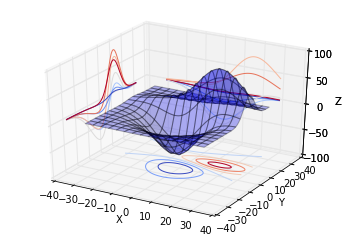

In [8]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()
